In [ ]:
%%capture
!pip install tensorboard==2.9.1
!pip install -q transformers pytorch_lightning emoji soynlp

In [ ]:
import os
import pandas as pd

from pprint import pprint

import tensorflow as tf
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim.lr_scheduler import ExponentialLR

from pytorch_lightning import LightningModule, Trainer, seed_everything
from pytorch_lightning.callbacks import ModelCheckpoint

from transformers import BertForSequenceClassification, BertTokenizer, AdamW,AutoModelForSequenceClassification,AutoTokenizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import re
import emoji
from soynlp.normalizer import repeat_normalize

#TPU 설정
# resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])

# tf.config.experimental_connect_to_cluster(resolver)
# tf.tpu.experimental.initialize_tpu_system(resolver)

In [ ]:
from google.colab import drive
drive.mount('/content/mydrive')

Drive already mounted at /content/mydrive; to attempt to forcibly remount, call drive.mount("/content/mydrive", force_remount=True).


# Data EDA

## train data

In [ ]:
data_path = '/content/mydrive/MyDrive/AIFFELTHON/nlp_data/data_processing_re(82681).xlsx'

In [ ]:
data = pd.read_excel(data_path)
data = data.iloc[:,:2]

In [ ]:
data

,content,emotion
0,아내가 드디어 출산하게 되어서 정말 신이 나.,기쁨
1,당뇨랑 합병증 때문에 먹어야 할 약이 열 가지가 넘어가니까 스트레스야.,긴장
2,고등학교에 올라오니 중학교 때보다 수업이 갑자기 어려워져서 당황스러워.,긴장
3,재취업이 돼서 받게 된 첫 월급으로 온 가족이 외식을 할 예정이야. 너무 행복해.,기쁨
4,빚을 드디어 다 갚게 되어서 이제야 안도감이 들어.,평화
...,...,...
82676,솔직히 예보 제대로 못하는 데 세금이라도 아끼게 그냥 폐지해라..,분노
82677,재미가 없으니 망하지,분노
82678,공장 도시락 비우생적임 아르바이트했는데 화장실가성 손도 않씯고 재료 담고 바닥 떨어...,분노
82679,코딱지 만한 나라에서 지들끼리 피터지게 싸우는 센징 클래스 ㅉㅉㅉ,분노


In [ ]:
data.isna().sum()

content    1
emotion    0
dtype: int64

In [ ]:
data = data.dropna()
data.reset_index(drop=True)

,content,emotion
0,아내가 드디어 출산하게 되어서 정말 신이 나.,기쁨
1,당뇨랑 합병증 때문에 먹어야 할 약이 열 가지가 넘어가니까 스트레스야.,긴장
2,고등학교에 올라오니 중학교 때보다 수업이 갑자기 어려워져서 당황스러워.,긴장
3,재취업이 돼서 받게 된 첫 월급으로 온 가족이 외식을 할 예정이야. 너무 행복해.,기쁨
4,빚을 드디어 다 갚게 되어서 이제야 안도감이 들어.,평화
...,...,...
82675,솔직히 예보 제대로 못하는 데 세금이라도 아끼게 그냥 폐지해라..,분노
82676,재미가 없으니 망하지,분노
82677,공장 도시락 비우생적임 아르바이트했는데 화장실가성 손도 않씯고 재료 담고 바닥 떨어...,분노
82678,코딱지 만한 나라에서 지들끼리 피터지게 싸우는 센징 클래스 ㅉㅉㅉ,분노


In [ ]:
data.isna().sum()

content    0
emotion    0
dtype: int64

In [ ]:
data['emotion'].unique()

array(['기쁨', '긴장', '평화', '슬픔', '분노', '중립'], dtype=object)

In [ ]:
data.loc[(data['emotion'] == "기쁨"), 'emotion'] = 0  #기쁨 => 0
data.loc[(data['emotion'] == "긴장"), 'emotion'] = 1  #긴장 => 1
data.loc[(data['emotion'] == "평화"), 'emotion'] = 2  #평화 => 2
data.loc[(data['emotion'] == "슬픔"), 'emotion'] = 3  #슬픔 => 3
data.loc[(data['emotion'] == "분노"), 'emotion'] = 4  #분노 => 4
data.loc[(data['emotion'] == "중립"), 'emotion'] = 5  #중립 => 5

In [ ]:
data.head()

,content,emotion
0,아내가 드디어 출산하게 되어서 정말 신이 나.,0
1,당뇨랑 합병증 때문에 먹어야 할 약이 열 가지가 넘어가니까 스트레스야.,1
2,고등학교에 올라오니 중학교 때보다 수업이 갑자기 어려워져서 당황스러워.,1
3,재취업이 돼서 받게 된 첫 월급으로 온 가족이 외식을 할 예정이야. 너무 행복해.,0
4,빚을 드디어 다 갚게 되어서 이제야 안도감이 들어.,2


In [ ]:
# data.to_csv('/content/drive/MyDrive/Aiffel/AIFFELTON/감성대화/sen_data.csv')

In [ ]:
data.emotion.unique()

array([0, 1, 2, 3, 4, 5], dtype=object)

In [ ]:
len_list = []
sen_list = []
for i,j in enumerate(data['content']):
    len_list.append(len(j))
    sen_list.append((i,j))

In [ ]:
sen_list.sort()
len_list.sort()
# sorted(len_list,key=len_list[1])
sen_list[-4][0]

82676

In [ ]:
len_list[1]

2

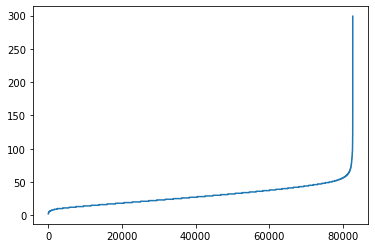

In [ ]:
import seaborn as sns
sns.lineplot(data=len_list)

In [ ]:
for i in sen_list:
    if len(i[1]) == 51:
        print(i[0],i[1])

116 우리 시어머니는 나를 볼 때마다 나한테 왜 아들을 못 낳았냐고 말씀하셔서 시댁에 가기 싫어.
175 병 관리와 생계유지를 위해 아내와 가게를 차렸는데 장사가 잘 안 돼 가게 문을 닫게 생겼어.
229 남편도 나도 만성 질환으로 지속적인 치료가 필요한 상황이지만 경제적으로 여유로워서 다행이야.
265 친구 중에 예쁜 친구가 있는데 주변에서 계속 그 친구 전화번호를 나한테 물어봐서 기분 나빠.
466 이번에 한의원에서 보약을 지어왔는데 술을 먹지 못해서 친구들과의 술자리에 다 못 가게 됐어.
508 좋은 기회로 이직할 수 있는 제안이 들어왔는데 이직을 해야 할지 말아야 할지 너무 고민이야.
569 겨우 구한 일자리인데 속없는 친구 놈이 치사하게 혼자만 돈을 버냐고 말해서 너무 화가 났어.
621 요즘 아이들이 학교에 안 나가서 내가 매일 밥을 해줘야 하는데 그게 여간 성가신 게 아니야.
636 내 주위에 괴롭힘을 당하는 친구가 있어. 분명 나에게 도움을 청할 거야. 난 그렇게 자신해.
678 참 어이가 없어. 돈 빌릴 때는 그렇게 친한 척을 하더니 갚을 때가 되니까 나를 피하더라고.
897 아내가 아이들에게 공부를 못하는 이유가 나를 닮아서 머리가 나빠서라고 말하는 게 기분 나빠.
1148 매번 똑같은 등산 코스를 오르는데 다른 길로 접어들어. 건망증이 생긴 건 아닐까 걱정이 돼.
1260 요즘 주식이 많이 오른 걸 보면 예전에 아내가 사라고 했던 주식을 사지 않은 게 후회스러워.
1378 의사는 내게 완치할 수 있다고 말했지만 내가 생각했을 땐 힘들 것 같아. 착잡하고 불안하네.
1422 결혼을 앞둔 여자친구가 수천만 원의 빚이 있대. 명품으로 치장한 게 다 빚이었다니 실망이야.
1427 정말 열심히 건강을 위해 운동했는데 갑자기 사고가 나서 사망하게 되면 너무 억울할 것 같아.
1454 다른 팀 직원이 나한테 직접 일을 시키는 것 아니라고 봐서 상사에게 얘기했어. 어이없지 참.
1632 다들 결혼자금으로 일억 정도는 모아놨는데 난 뭐 하느라 이만큼밖에 

In [ ]:
len('하여간 얼굴색 하나 안 변하고 뻔뻔하게 거짓말 잘하는 여자라는건 대한민국에서 알아줘야 한다.')

51

In [ ]:
data.emotion.unique()

array([0, 1, 2, 3, 4, 5], dtype=object)

In [ ]:
# x_train,x_val = train_test_split(data,test_size=0.2,random_state=42)
# x_train.to_csv('/content/drive/MyDrive/Aiffel/AIFFELTON/감성대화/sen_train.csv')
# x_val.to_csv('/content/drive/MyDrive/Aiffel/AIFFELTON/감성대화/sen_val.csv')

## lyric data

In [ ]:
lyric_path = '/content/mydrive/MyDrive/AIFFELTHON/lyric_data/lyrics_v1.tsv'
lyric = pd.read_csv(lyric_path, sep = '\t')

In [ ]:
lyric.head()

,song_id,song_name,lyric,artist,genre,album,album_id,release
0,30310140.0,"사랑, 그대라는 멜로디",그대 스치는 바람처럼 불어와서 내 곁에 머무른 사람 나도 몰래 내쉬는 숨처럼 익숙해...,진호,GN0100,Pastel Reflection,10047088,20170320
1,8068890.0,Girl Crush,이따 거기서 봐 이번엔 장담해 찾았어 Hot place 예감이 괜찮아 정말로 기대돼...,마마무 (Mamamoo),"GN2500,GN0200",Melting,2669407,20160226
2,5579388.0,무얼 기다리나 (Feat. 조원선),그냥 생각 없이 이렇다 할 뜻도 없이 쉼 없이 웃으며 떠드는 이들을 가만히 두리번거...,이영훈,"GN0500,GN0800",내가 부른 그림 2,2303168,20150205
3,86313.0,뒤돌아봐,뒤돌아봐 난 난 너를 기다리고 있어 애써 감추려 하지마 그 맘을 이제 열어요 이제는...,업타운,GN0300,다시 만나줘,5421,19970114
4,3953129.0,창밖에 잠수교가 보인다,너를보면 나는 잠이와 이상하다 그치 잠이오면 나는 잠을자 이상하다 그치 자면서 너에...,박영민,GN1500,창밖에 잠수교가 보인다 OST,2165909,19840910


In [ ]:
lyric_ = pd.DataFrame()
lyric_['lyric'] = lyric.lyric
lyric_.head()

,lyric
0,그대 스치는 바람처럼 불어와서 내 곁에 머무른 사람 나도 몰래 내쉬는 숨처럼 익숙해...
1,이따 거기서 봐 이번엔 장담해 찾았어 Hot place 예감이 괜찮아 정말로 기대돼...
2,그냥 생각 없이 이렇다 할 뜻도 없이 쉼 없이 웃으며 떠드는 이들을 가만히 두리번거...
3,뒤돌아봐 난 난 너를 기다리고 있어 애써 감추려 하지마 그 맘을 이제 열어요 이제는...
4,너를보면 나는 잠이와 이상하다 그치 잠이오면 나는 잠을자 이상하다 그치 자면서 너에...


In [ ]:
lyric_.isnull().sum()

lyric    0
dtype: int64

In [ ]:
lyric_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1033 entries, 0 to 1032
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   lyric   1033 non-null   object
dtypes: object(1)
memory usage: 8.2+ KB


# data_load

In [ ]:
# data_pro = pd.read_excel('/content/drive/MyDrive/Aiffel/AIFFELTON/data_processing.xlsx')
# data_pro

In [ ]:
data_pro = data.copy()

In [ ]:
data_pro = data_pro.rename(columns={'emotion':'label'})

In [ ]:
data_pro.head()

,content,label
0,아내가 드디어 출산하게 되어서 정말 신이 나.,0
1,당뇨랑 합병증 때문에 먹어야 할 약이 열 가지가 넘어가니까 스트레스야.,1
2,고등학교에 올라오니 중학교 때보다 수업이 갑자기 어려워져서 당황스러워.,1
3,재취업이 돼서 받게 된 첫 월급으로 온 가족이 외식을 할 예정이야. 너무 행복해.,0
4,빚을 드디어 다 갚게 되어서 이제야 안도감이 들어.,2


In [ ]:
# data_pro = data_pro.drop(['emotion'],axis=1)
# data_pro

In [ ]:
x_tr,x_val = train_test_split(data_pro,stratify=data_pro['label'],test_size=0.2,random_state=42)

In [ ]:
x_tr.shape,x_val.shape

((66144, 2), (16536, 2))

In [ ]:
x_tr.label.value_counts(),x_val.label.value_counts()

(3    19065
 4    16433
 1    16177
 0     8870
 5     3861
 2     1738
 Name: label, dtype: int64, 3    4766
 4    4108
 1    4045
 0    2217
 5     966
 2     434
 Name: label, dtype: int64)

In [ ]:
# x_tr.to_csv('/content/drive/MyDrive/Aiffel/AIFFELTON/preprocessing_data/propressing_train.csv',index=False)
# x_val.to_csv('/content/drive/MyDrive/Aiffel/AIFFELTON/preprocessing_data/propressing_val.csv',index=False)

In [ ]:
pre_path = '/content/mydrive/MyDrive/AIFFELTHON/preprocessed'
x_tr.to_csv(pre_path+'/pre_train.csv', index=False)
x_val.to_csv(pre_path+'/pre_val.csv', index=False)

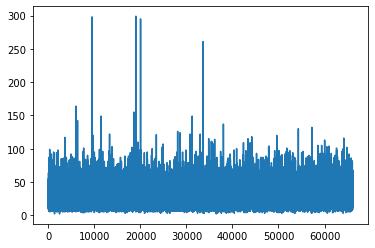

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
tr = pd.read_csv(pre_path+'/pre_train.csv')
leng = []
for i in tr.content:
    leng.append(len(i))
sns.lineplot(data=leng)

# model setting

In [ ]:
class Arg:
    random_seed: int = 42 # Random Seed
    pretrained_model: str = 'klue/roberta-large'  # Transformers PLM name
    pretrained_tokenizer: str = ''  # Optional, Transformers Tokenizer Name. Overrides `pretrained_model`
    auto_batch_size: str = 'power'  # Let PyTorch Lightening find the best batch size
    # auto_batch_size: str = 'binsearch'
    batch_size: int = 0  # Optional, Train/Eval Batch Size. Overrides `auto_batch_size` 
    lr: float = 5e-6  # Starting Learning Rate
    epochs: int = 3  # Max Epochs
    max_length: int = 100  # Max Length input size
    report_cycle: int = 100  # Report (Train Metrics) Cycle
    train_data_path: str = pre_path+'/pre_train.csv'  # Train Dataset file 
    val_data_path: str = pre_path+'/pre_val.csv'  # Validation Dataset file 
    cpu_workers: int = os.cpu_count()  # Multi cpu workers
    test_mode: bool = False  # Test Mode enables `fast_dev_run`
    optimizer: str = 'AdamW'  # AdamW vs AdamP
    lr_scheduler: str = 'exp'  # ExponentialLR vs CosineAnnealingWarmRestarts
    fp16: bool = False  # Enable train on FP16
    tpu_cores: int = 0  # Enable TPU with 1 core or 8 cores

args = Arg()

In [ ]:
# args.tpu_cores = 8  # Enables TPU
args.fp16 = True  # Enables GPU FP16
args.batch_size = 16  # Force setup batch_size
tr_met_list,val_met_list = [],[]

## callback
ckpt_path = '/content/mydrive/MyDrive/AIFFELTHON/test_model'
checkpoint_callback = ModelCheckpoint(
    monitor = 'val_loss',
    dirpath = ckpt_path,
    filename = 'KcBert-{epoch:02d}-{val_loss:.2f}'
)


In [ ]:
class Model(LightningModule):
    def __init__(self, options):
        super().__init__()
        self.args = options
        self.bert = AutoModelForSequenceClassification.from_pretrained(self.args.pretrained_model,num_labels=6) #num_labels == 태그 개수
        self.tokenizer = AutoTokenizer.from_pretrained(
            self.args.pretrained_tokenizer
            if self.args.pretrained_tokenizer
            else self.args.pretrained_model
        )

    def forward(self, **kwargs):
        return self.bert(**kwargs)

    def training_step(self, batch, batch_idx):
        data_, labels = batch
        output = self(input_ids=data_, labels=labels)

        # Transformers 4.0.0+
        loss = output.loss
        logits = output.logits
        
        preds = logits.argmax(dim=-1)

        y_true = labels.cpu().numpy()
        y_pred = preds.cpu().numpy()

        # Acc, Precision, Recall, F1
        metrics = [
            metric(y_true=y_true, y_pred=y_pred,average='weighted')
            for metric in
            (precision_score, recall_score, f1_score)
        ]

        tensorboard_logs = {
            'train_loss': loss.cpu().detach().numpy().tolist(),
            # 'train_acc': metrics[0],
            'train_precision': metrics[0],
            'train_recall': metrics[1],
            'train_f1': metrics[2],
        }
        tr_met_list.append(tensorboard_logs)
        if (batch_idx % self.args.report_cycle) == 0:
            print()
          
            pprint(tensorboard_logs)
        return {'loss': loss, 'log': tensorboard_logs}

    def validation_step(self, batch, batch_idx):
        data_, labels = batch
        output = self(input_ids=data_, labels=labels)

        # Transformers 4.0.0+
        loss = output.loss
        logits = output.logits

        preds = logits.argmax(dim=-1)

        y_true = list(labels.cpu().numpy())
        y_pred = list(preds.cpu().numpy())

        return {
            'loss': loss,
            'y_true': y_true,
            'y_pred': y_pred,
        }

    def validation_epoch_end(self, outputs):
        loss = torch.tensor(0, dtype=torch.float)
        for i in outputs:
            loss += i['loss'].cpu().detach()
        _loss = loss / len(outputs)

        loss = float(_loss)
        y_true = []
        y_pred = []

        for i in outputs:
            y_true += i['y_true']
            y_pred += i['y_pred']

        # Acc, Precision, Recall, F1
        metrics = [
            metric(y_true=y_true, y_pred=y_pred,average='weighted')
            for metric in
            (precision_score, recall_score, f1_score)
        ]

        tensorboard_logs = {
            'val_loss': loss,
            # 'val_acc': metrics[0],
            'val_precision': metrics[0],
            'val_recall': metrics[1],
            'val_f1': metrics[2],
        }
        ## callback
        self.log('val_loss',loss)
        tensorboard_logs = {
            'val_loss': loss,
            # 'val_acc': metrics[0],
            # 'val_precision': metrics[1],
            # 'val_recall': metrics[2],
            # 'val_f1': metrics[3],
            'val_precision': metrics[0],
            'val_recall': metrics[1],
            'val_f1': metrics[2],
        }
        val_met_list.append(tensorboard_logs)
        print()
        pprint(tensorboard_logs)
        return {'loss': _loss, 'log': tensorboard_logs}

    def configure_optimizers(self):
        if self.args.optimizer == 'AdamW':
            optimizer = AdamW(self.parameters(), lr=self.args.lr)
        elif self.args.optimizer == 'AdamP':
            from adamp import AdamP
            optimizer = AdamP(self.parameters(), lr=self.args.lr)
        else:
            raise NotImplementedError('Only AdamW and AdamP is Supported!')
        if self.args.lr_scheduler == 'cos':
            scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=1, T_mult=2)
        elif self.args.lr_scheduler == 'exp':
            scheduler = ExponentialLR(optimizer, gamma=0.5)
        else:
            raise NotImplementedError('Only cos and exp lr scheduler is Supported!')
        return {
            'optimizer': optimizer,
            'scheduler': scheduler,
        }

    def read_data(self, path):
        if path.endswith('xlsx'):
            return pd.read_excel(path)
        elif path.endswith('csv'):
            return pd.read_csv(path)
        elif path.endswith('tsv') or path.endswith('txt'):
            return pd.read_csv(path, sep='\t')
        else:
            raise NotImplementedError('Only Excel(xlsx)/Csv/Tsv(txt) are Supported')

    def preprocess_dataframe(self, df):
        # emojis = ''.join(emoji.UNICODE_EMOJI.keys())
        pattern = re.compile(f'[^ .,?!/@$%~％·∼()\x00-\x7Fㄱ-힣]+')
        url_pattern = re.compile(
            r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)')

        def clean(x):
            x = pattern.sub(' ', x)
            x = url_pattern.sub('', x)
            x = x.strip()
            x = repeat_normalize(x, num_repeats=2) # ㅋㅋㅋㅋㅋㅋ .. -> ㅋㅋ 같이 반복되는 문자에 대해 변환 
            return x

        df['content'] = df['content'].map(lambda x: self.tokenizer.encode(
            clean(str(x)),
            padding='max_length',
            max_length=self.args.max_length,
            truncation=True,
        ))
        return df

    def train_dataloader(self):
        df = self.read_data(self.args.train_data_path)
        df = self.preprocess_dataframe(df)

        dataset = TensorDataset(
            torch.tensor(df['content'].to_list(), dtype=torch.long),
            torch.tensor(df['label'].to_list(), dtype=torch.long),
        )
        return DataLoader(
            dataset,
            batch_size=self.args.batch_size or self.batch_size,
            shuffle=True,
            num_workers=self.args.cpu_workers,
        )

    def val_dataloader(self):
        df = self.read_data(self.args.val_data_path)
        df = self.preprocess_dataframe(df)

        dataset = TensorDataset(
            torch.tensor(df['content'].to_list(), dtype=torch.long),
            torch.tensor(df['label'].to_list(), dtype=torch.long),
        )
        return DataLoader(
            dataset,
            batch_size=self.args.batch_size or self.batch_size,
            shuffle=False,
            num_workers=self.args.cpu_workers,
        )


In [ ]:
def main():
    print("Using PyTorch Ver", torch.__version__)
    print("Fix Seed:", args.random_seed)
    seed_everything(args.random_seed)
    model = Model(args)
    # summary(model)
    print(":: Start Training ::")
    trainer = Trainer(
        # callbacks = [checkpoint_callback],
        max_epochs=args.epochs,
        fast_dev_run=args.test_mode,
        num_sanity_val_steps=None if args.test_mode else 0,
        auto_scale_batch_size=args.auto_batch_size if args.auto_batch_size and not args.batch_size else False,
        # For GPU Setup
        deterministic=torch.cuda.is_available(),
        gpus=-1 if torch.cuda.is_available() else None,
        precision=16 if args.fp16 else 32,
        # For TPU Setup
        # tpu_cores=args.tpu_cores if args.tpu_cores else None,
    )
    trainer.fit(model)

    # save model
    torch.save(model.state_dict(), 'test_model.ckpt')

In [ ]:
# from torchsummary import summary
# summary(model)

In [ ]:
import warnings
warnings.filterwarnings('ignore') 
main()

INFO:pytorch_lightning.utilities.seed:Global seed set to 42


Using PyTorch Ver 1.12.1+cu113
Fix Seed: 42


Some weights of the model checkpoint at klue/roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at klue/roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classif

:: Start Training ::


INFO:pytorch_lightning.utilities.rank_zero:Using 16bit native Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name | Type                             | Params
----------------------------------------------------------
0 | bert | RobertaForSequenceClassification | 336 M 
----------------------------------------------------------
336 M     Trainable params
0         Non-trainable params
336 M     Total params
673.325   Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]


{'train_f1': 0.17752100840336135,
 'train_loss': 1.79425048828125,
 'train_precision': 0.2139423076923077,
 'train_recall': 0.25}

{'train_f1': 0.1875,
 'train_loss': 1.527008056640625,
 'train_precision': 0.15625,
 'train_recall': 0.25}

{'train_f1': 0.5214743589743589,
 'train_loss': 1.054290771484375,
 'train_precision': 0.53125,
 'train_recall': 0.5625}

{'train_f1': 0.6961538461538461,
 'train_loss': 0.8222846984863281,
 'train_precision': 0.7276785714285714,
 'train_recall': 0.6875}

{'train_f1': 0.7810921717171717,
 'train_loss': 0.6752586364746094,
 'train_precision': 0.8645833333333333,
 'train_recall': 0.75}

{'train_f1': 0.4,
 'train_loss': 0.9282302856445312,
 'train_precision': 0.40625,
 'train_recall': 0.4375}

{'train_f1': 0.875,
 'train_loss': 0.7007637023925781,
 'train_precision': 0.875,
 'train_recall': 0.875}

{'train_f1': 0.6979166666666666,
 'train_loss': 0.7183647155761719,
 'train_precision': 0.8208333333333333,
 'train_recall': 0.6875}

{'train_f1': 0.58712121

Validation: 0it [00:00, ?it/s]


{'val_f1': 0.7101682383100257,
 'val_loss': 0.7393439412117004,
 'val_precision': 0.7118085065272591,
 'val_recall': 0.7137760038703435}

{'train_f1': 0.6596153846153846,
 'train_loss': 0.807891845703125,
 'train_precision': 0.75,
 'train_recall': 0.625}

{'train_f1': 0.8958333333333333,
 'train_loss': 0.4723224639892578,
 'train_precision': 0.96875,
 'train_recall': 0.875}

{'train_f1': 0.8089285714285714,
 'train_loss': 0.748176097869873,
 'train_precision': 0.8625,
 'train_recall': 0.8125}

{'train_f1': 0.5488095238095239,
 'train_loss': 1.0825996398925781,
 'train_precision': 0.765625,
 'train_recall': 0.5625}

{'train_f1': 0.8125,
 'train_loss': 0.4453277587890625,
 'train_precision': 0.84375,
 'train_recall': 0.8125}

{'train_f1': 0.8689236111111113,
 'train_loss': 0.6222953796386719,
 'train_precision': 0.9027777777777778,
 'train_recall': 0.875}

{'train_f1': 0.6822916666666666,
 'train_loss': 0.9122748374938965,
 'train_precision': 0.7375,
 'train_recall': 0.6875}

{'train_f1

Validation: 0it [00:00, ?it/s]


{'val_f1': 0.7185491563500424,
 'val_loss': 0.731860876083374,
 'val_precision': 0.7183721042726241,
 'val_recall': 0.7238147073052733}

{'train_f1': 0.8816964285714286,
 'train_loss': 0.3675837516784668,
 'train_precision': 0.925,
 'train_recall': 0.875}

{'train_f1': 0.8154761904761906,
 'train_loss': 0.5576200485229492,
 'train_precision': 0.84375,
 'train_recall': 0.8125}

{'train_f1': 0.5627705627705628,
 'train_loss': 0.8611564636230469,
 'train_precision': 0.5491071428571428,
 'train_recall': 0.625}

{'train_f1': 0.7281746031746031,
 'train_loss': 0.6922883987426758,
 'train_precision': 0.725,
 'train_recall': 0.75}

{'train_f1': 0.5383928571428571,
 'train_loss': 0.8933827877044678,
 'train_precision': 0.6770833333333333,
 'train_recall': 0.5625}

{'train_f1': 0.6227678571428571,
 'train_loss': 0.9357891082763672,
 'train_precision': 0.6541666666666668,
 'train_recall': 0.625}

{'train_f1': 0.8736111111111111,
 'train_loss': 0.5245046615600586,
 'train_precision': 0.9166666666

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.



{'val_f1': 0.7229809992155702,
 'val_loss': 0.7606109380722046,
 'val_precision': 0.722188396310681,
 'val_recall': 0.7260522496371553}


In [ ]:
loss,precision,recall,f1 = [],[],[],[]
for i in range(len(tr_met_list)):
    loss.append(tr_met_list[i]['train_loss'])
    precision.append(tr_met_list[i]['train_precision'])
    recall.append(tr_met_list[i]['train_recall'])
    f1.append(tr_met_list[i]['train_f1'])

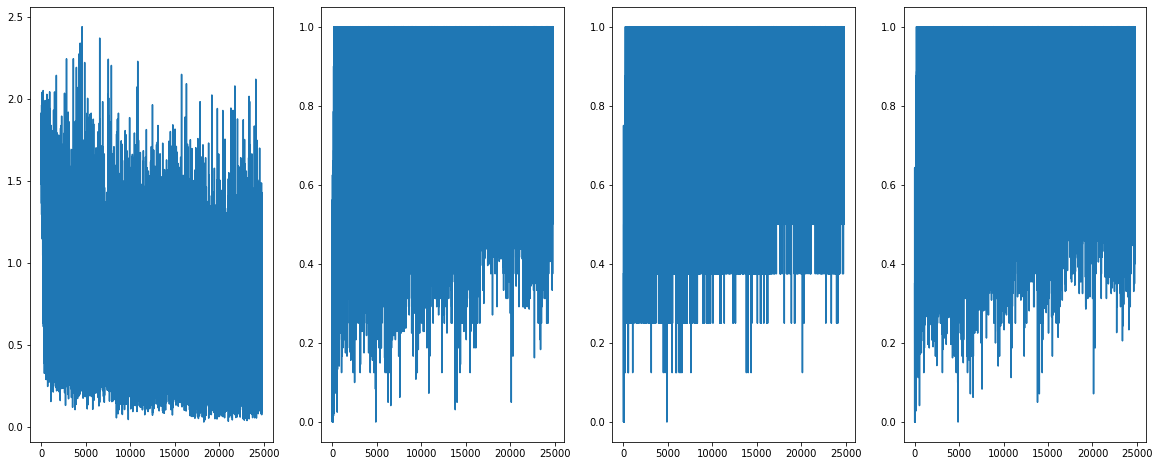

<Figure size 1440x576 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, axes = plt.subplots(1, 4,figsize=(20,8))
plt.figure(figsize=(20,8))
sns.lineplot(data=loss,ax=axes[0])
sns.lineplot(data=precision,ax=axes[1])
sns.lineplot(data=recall,ax=axes[2])
sns.lineplot(data=f1,ax=axes[3])

In [ ]:
loss,precision,recall,f1 = [],[],[],[]
for i in range(len(val_met_list)):
    loss.append(val_met_list[i]['val_loss'])
    precision.append(val_met_list[i]['val_precision'])
    recall.append(val_met_list[i]['val_recall'])
    f1.append(val_met_list[i]['val_f1'])

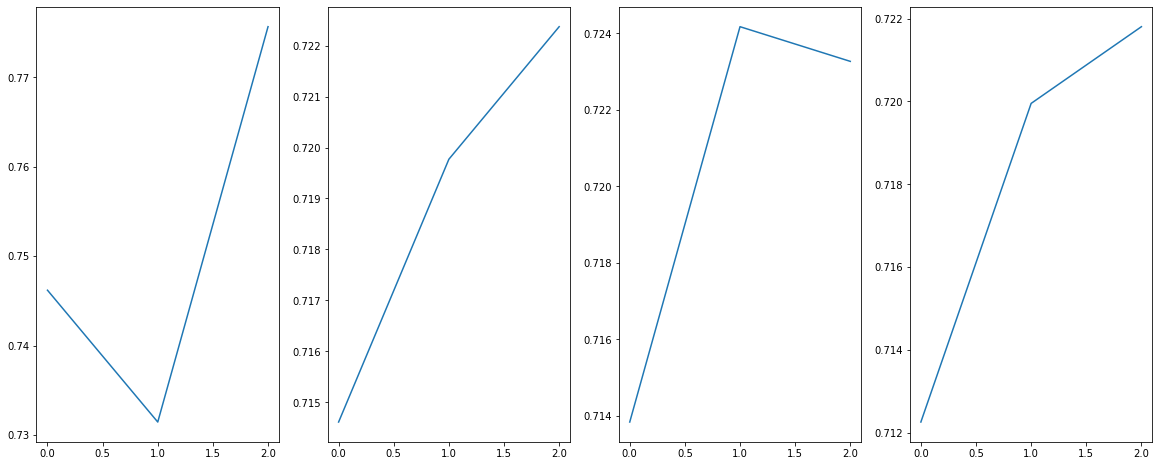

<Figure size 1440x576 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 4,figsize=(20,8))
plt.figure(figsize=(20,8))
sns.lineplot(data=loss,ax=axes[0])
sns.lineplot(data=precision,ax=axes[1])
sns.lineplot(data=recall,ax=axes[2])
sns.lineplot(data=f1,ax=axes[3])

# 결과

In [ ]:
'''
<basic arg setting>

random seed = 42
batch size = 32
learning rate = 5e-6
max length = 150
epoch = 3
optimizer = AdamW
'''

# class Arg:
#     random_seed: int = 42 # Random Seed
#     pretrained_model: str = 'klue/roberta-large'  # Transformers PLM name
#     pretrained_tokenizer: str = ''  # Optional, Transformers Tokenizer Name. Overrides `pretrained_model`
#     auto_batch_size: str = 'power'  # Let PyTorch Lightening find the best batch size
#     # auto_batch_size: str = 'binsearch'
#     batch_size: int = 0  # Optional, Train/Eval Batch Size. Overrides `auto_batch_size` 
#     lr: float = 5e-6  # Starting Learning Rate
#     epochs: int = 3  # Max Epochs
#     max_length: int = 150  # Max Length input size
#     report_cycle: int = 100  # Report (Train Metrics) Cycle
#     train_data_path: str = pre_path+'/pre_train.csv'  # Train Dataset file 
#     val_data_path: str = pre_path+'/pre_val.csv'  # Validation Dataset file 
#     cpu_workers: int = os.cpu_count()  # Multi cpu workers
#     test_mode: bool = False  # Test Mode enables `fast_dev_run`
#     optimizer: str = 'AdamW'  # AdamW vs AdamP
#     lr_scheduler: str = 'exp'  # ExponentialLR vs CosineAnnealingWarmRestarts
#     fp16: bool = False  # Enable train on FP16
#     tpu_cores: int = 0  # Enable TPU with 1 core or 8 cores

# # args.tpu_cores = 8  # Enables TPU
# args.fp16 = True  # Enables GPU FP16
# args.batch_size = 16  # Force setup batch_size
# tr_met_list,val_met_list = [],[]

'\n<basic arg setting>\n\nrandom seed = 42\nbatch size = 32\nlearning rate = 5e-6\nmax length = 150\nepoch = 3\noptimizer = AdamW\n'

- batch size 16, max length 150

val loss | val f1 score | val precision | val recall
:--|:--|:--|:--
0.769 | 0.719 | 0.719 | 0.723

- batch size 32, max length 150

val loss | val f1 score | val precision | val recall
:--|:--|:--|:--
0.758 | 0.714 | 0.718 | 0.720

- batch size 16, max length 100

val loss | val f1 score | val precision | val recall
:--|:--|:--|:--
0.761 | 0.723 | 0.722 | 0.726

- batch size 32, max length 100

val loss | val f1 score | val precision | val recall
:--|:--|:--|:--
0.765 | 0.715 | 0.717 | 0.720

- batch size 8, max length 150

val loss | val f1 score | val precision | val recall
:--|:--|:--|:--
0.776 | 0.722 | 0.722 | 0.723